<a href="https://colab.research.google.com/github/kirmel4/MovieReviewClassifierRNN/blob/main/MovieReviewClassifierRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.utils import np_utils
from keras.preprocessing import text
from sklearn import preprocessing, decomposition, model_selection, metrics
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


#Data Collection

In [ ]:
! pip install -q kaggle
import os
from google.colab import files
if not os.path.exists("/root/.kaggle/kaggle.json"):
  files.upload()
  ! mkdir -p ~/.kaggle
  ! mv kaggle.json ~/.kaggle/ 
  ! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d nltkdata/movie-review

 99% 7.00M/7.07M [00:01<00:00, 8.95MB/s]
100% 7.07M/7.07M [00:01<00:00, 5.53MB/s]


In [ ]:
!unzip -qq movie-review.zip -d ./main

In [ ]:
data = pd.read_csv('/content/main/movie_review.csv')

In [ ]:
data.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


#Data Preprocessing

In [ ]:
data['tag'] = data['tag'].map({'pos': 1, 'neg': 0})

In [ ]:
data['tag'].value_counts()

1    32937
0    31783
Name: tag, dtype: int64

In [ ]:
data.drop(['fold_id', 'cv_tag', 'html_id', 'sent_id'], axis =1, inplace = True)

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(data.text.values, data.tag.values, 
                                                  stratify=data.tag.values, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [ ]:
#xvalid, xtest, yvalid, ytest = train_test_split(xvalid, yvalid, 
#                                                  stratify=yvalid, 
#                                                  random_state=42, 
#                                                 test_size=0.5, shuffle=True)


Stemming and lemmatization

In [ ]:
def stopwords(data):
  filtered_data = []
  for text_ in data:
    filtered_sentence = []
    for w in text_:
      if w not in stop_words:
        filtered_sentence.append(w)
    filtered_data.append(filtered_sentence)
  return filtered_data

In [ ]:
lemmatizer = WordNetLemmatizer()
def lem(data):
  new_data = []
  for text_ in data:
    new_text = []
    for word in text_.split():
      new_text.append(lemmatizer.lemmatize(word))
    new_data.append(new_text)
  return new_data

In [ ]:
xtrain = lem(xtrain)
xtrain = stopwords(xtrain)

In [ ]:
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

Padding

In [ ]:
def FindMaxLength(lst):
    maxList = max((x) for x in lst)
    maxLength = max(len(x) for x in lst )
    return maxList, maxLength

In [ ]:
max_len = FindMaxLength(list(xtrain_seq) + list(xvalid_seq))[1]

In [ ]:
max_len #Length of the longest text

136

In [ ]:
#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
len(word_index)

43296

#Model Selection

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 136, 300)          14374800  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 14,415,001
Trainable params: 14,415,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Import the necessary modules
import matplotlib.pyplot as plt  # Train your model and collect the history
history = model.fit(xtrain_pad, ytrain, epochs=10, validation_data=(xvalid_pad, yvalid))  # Plot the training and validation loss 

Epoch 1/10
1821/1821 [==============================] - 274s 146ms/step - loss: 0.6941 - accuracy: 0.5219 - val_loss: 0.7079 - val_accuracy: 0.4930
Epoch 2/10
1821/1821 [==============================] - 237s 130ms/step - loss: 0.6389 - accuracy: 0.6410 - val_loss: 0.6780 - val_accuracy: 0.5763
Epoch 3/10
1821/1821 [==============================] - 234s 128ms/step - loss: 0.5221 - accuracy: 0.7497 - val_loss: 0.6513 - val_accuracy: 0.6343
Epoch 4/10
1821/1821 [==============================] - 233s 128ms/step - loss: 0.4140 - accuracy: 0.8134 - val_loss: 0.6780 - val_accuracy: 0.6591
Epoch 5/10
1821/1821 [==============================] - 234s 128ms/step - loss: 0.3067 - accuracy: 0.8697 - val_loss: 0.7692 - val_accuracy: 0.6544
Epoch 6/10
1821/1821 [==============================] - 239s 131ms/step - loss: 0.2268 - accuracy: 0.9040 - val_loss: 0.8452 - val_accuracy: 0.6489
Epoch 7/10
1821/1821 [==============================] - 232s 128ms/step - loss: 0.1654 - accuracy: 0.9306 - val_

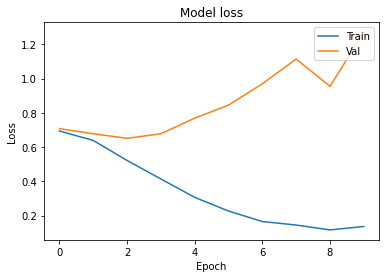

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()  # Plot the training and validation accuracy


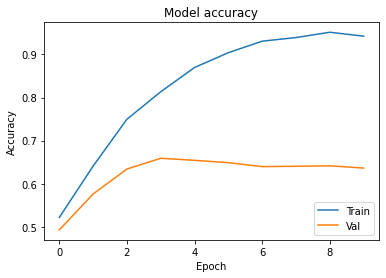

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
scores = model.fit(xvalid_pad, yvalid)

In [ ]:
print("AUC: %.2f%%" % (roc_auc(scores,yvalid)))

AUC: 0.69%
